In [97]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys import ecephys_session
%matplotlib inline

import sys
sys.path.append('../../swdb_2019_tools')
# import Neuropixels_timeseries
import spikeutils

# fix slow autocomplete
%config Completer.use_jedi = False

In [98]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # OS X 
    data_root = "/Volumes/Brain2019/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2019/"

manifest_path = os.path.join(data_root, "dynamic-brain-workshop/visual_coding_neuropixels/2019/manifest.json")

<b>Acquire Data</b>

In [99]:
cache = EcephysProjectCache.fixed(manifest=manifest_path)
sessions = cache.get_sessions()

#find all sessions with region of interest
hcareas = ['VISp']
hc_sessions = []
for i in np.arange(len(sessions.structure_acronyms)):
    sessionid = sessions.structure_acronyms.index[i]
    if any(elem in sessions.structure_acronyms[sessionid] for elem in hcareas):
        hc_sessions.append(sessionid)

#choose a session
# seshid = hc_sessions[2]
seshid = 759883607

#get all units and channels
allunits = cache.get_units(annotate=True)
channelinfo = cache.get_channels()

#choose units that are on appropriate channels
ca_channelinfo = channelinfo[channelinfo.manual_structure_acronym == hcareas[0]]
ca_units = allunits[(allunits.peak_channel_id.isin(ca_channelinfo.index))&(allunits.ecephys_session_id == seshid)]

#get session data for chosen session
session = cache.get_session_data(seshid)

##### different way to pull units (slower in my experience) #####
# ca_units = session.units[session.units.structure_acronym=='CA']

In [4]:
seshid

759883607

In [5]:
len(ca_units)

62

In [6]:
#get spike times for session
spike_times = session.spike_times

#use following two lines to make a list of spiketimes
ca_spiketimes = []
for i in range(len(ca_units)):
    unit_id = ca_units.index[i]
    ca_spiketimes.append(spike_times[unit_id])

<b>Stimulus Presentations</b>

In [7]:
# session.get_presentations_for_stimulus('natural_movie_three').stimulus_condition_id.value_counts()

In [8]:
driftgrat_presentations = session.get_presentations_for_stimulus(stimulus_names='drifting_gratings')
natscene_presentations = session.get_presentations_for_stimulus(stimulus_names='natural_scenes')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [9]:
ori_45 = driftgrat_presentations[(driftgrat_presentations.orientation==45)&(driftgrat_presentations.temporal_frequency==4)]
ori_315 = driftgrat_presentations[(driftgrat_presentations.orientation==315)&(driftgrat_presentations.temporal_frequency==4)]

In [10]:
nat_imga = natscene_presentations[natscene_presentations.frame==15]
nat_imgb = natscene_presentations[natscene_presentations.frame==72]

In [11]:
ntrials_drift = len(ori_45)
ntrials_nat = len(nat_imga)

<b>Bin spikes</b>

In [44]:
####FOR DRIFTING GRATINGS

binsize = 1

# #return 15 rows of binned fr
# #stimrates_45 = np.zeros(15*binsize,numunits)  #trials by N
# #stimrates_315 = np.zeros(15*binsize,numunits)

numunits = len(ca_spiketimes)

nbins_45 = np.int(np.ceil(((ori_45.stop_time.iloc[0]-(ori_45.start_time.iloc[0]))*1000)/binsize))
nbins_315 = np.int(np.ceil(((ori_315.stop_time.iloc[0]-(ori_315.start_time.iloc[0]))*1000)/binsize))

print(nbins_45)
print(nbins_315)

trialresponses_45 = np.zeros((nbins_45,numunits,ntrials_drift))
for i in range(ntrials_drift):
    starttime = ori_45.start_time.iloc[i]
    endtime = ori_45.start_time.iloc[i]+2.0017
    trialresponses_45[:,:,i] = spikeutils.spiketimes_to_2D_rates(ca_spiketimes, starttime,
                                        endtime, binsize=binsize).T

trialresponses_315 = np.zeros((nbins_315,numunits,ntrials_drift))
for i in range(ntrials_drift):
    starttime = ori_315.start_time.iloc[i]
    endtime = ori_315.start_time.iloc[i]+2.0017
    trialresponses_315[:,:,i] = spikeutils.spiketimes_to_2D_rates(ca_spiketimes,starttime,endtime,binsize=binsize).T

2002
2002
(2002, 62, 15)
(2002, 62, 15)


In [46]:
nbins_nat1

251

In [48]:
####FOR NATURAL SCENES

nbins_nat1 = np.int(np.ceil(((nat_imga.stop_time.iloc[0]-(nat_imga.start_time.iloc[0]))*1000)/binsize))
nbins_nat2 = np.int(np.ceil(((nat_imgb.stop_time.iloc[0]-(nat_imgb.start_time.iloc[0]))*1000)/binsize))

trialresponses_nat1 = np.zeros((nbins_nat1,numunits,ntrials_nat))
for i in range(ntrials_nat):
    starttime = nat_imga.start_time.iloc[i]
    endtime = nat_imga.stop_time.iloc[i]
    trialresponses_nat1[:,:,i] = spikeutils.spiketimes_to_2D_rates(ca_spiketimes, starttime,
                                        endtime, binsize=binsize).T
    
trialresponses_nat2 = np.zeros((nbins_nat2,numunits,ntrials_nat))
for i in range(ntrials_nat):
    starttime = nat_imgb.start_time.iloc[i]
    endtime = nat_imgb.stop_time.iloc[i]
    trialresponses_nat2[:,:,i] = spikeutils.spiketimes_to_2D_rates(ca_spiketimes, starttime,
                                        endtime, binsize=binsize).T

In [14]:
np.shape(trialresponses_45),np.shape(trialresponses_nat1)

((2002, 35, 15), (251, 35, 50))

<b>PSTH</b>

In [15]:
trialavgresponse_45 = np.mean(trialresponses_45,axis=2)
trialavgresponse_315 = np.mean(trialresponses_315,axis=2)
trialavgresponse_nat1 = np.mean(trialresponses_nat1,axis=2)
trialavgresponse_nat2 = np.mean(trialresponses_nat2,axis=2)

<i>Drifting Gratings PSTH</i>

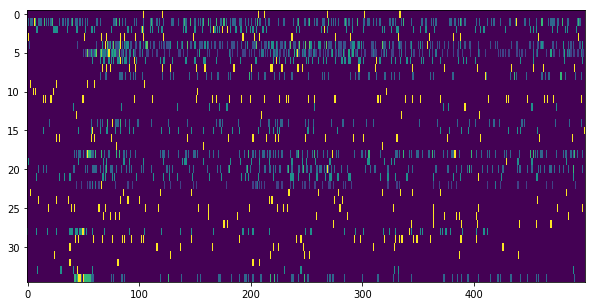

In [16]:
tavg_45 = trialavgresponse_45.T[:,0:500]
tavg_45_norm = (tavg_45 - np.min(tavg_45, axis=1)[:, np.newaxis]) / np.ptp(tavg_45, axis=1)[:, np.newaxis]
tavg_45_norm[np.isnan(tavg_45_norm)] = 0  #deal with the ugly nan rows

plt.figure(figsize=(10,5))
plt.imshow(tavg_45_norm,aspect='auto')
# plt.vlines(50,ymin=0,ymax=numunits-1,color='white')

# plt.figure(figsize=(10,5))
# plt.imshow(trialresponses_45[:,:,5].T[:,0:500],aspect='auto')
# plt.vlines(50,ymin=0,ymax=numunits,color='white')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


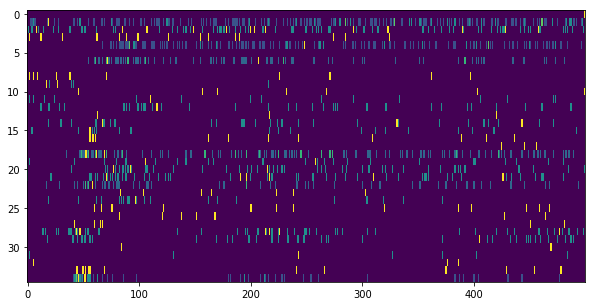

In [17]:
tavg_315 = trialavgresponse_315.T[:,0:500]
tavg_315_norm = (tavg_315 - np.min(tavg_315, axis=1)[:, np.newaxis]) / np.ptp(tavg_315, axis=1)[:, np.newaxis]
tavg_315_norm[np.isnan(tavg_315_norm)] = 0  #deal with the ugly nan rows

plt.figure(figsize=(10,5))
plt.imshow(tavg_315_norm,aspect='auto')
# plt.vlines(50,ymin=0,ymax=numunits-1,color='white')

# plt.figure(figsize=(10,5))
# plt.imshow(trialresponses_45[:,:,5].T[:,0:500],aspect='auto')
# plt.vlines(50,ymin=0,ymax=numunits,color='white')

<i>Natural Scene PSTH</i>

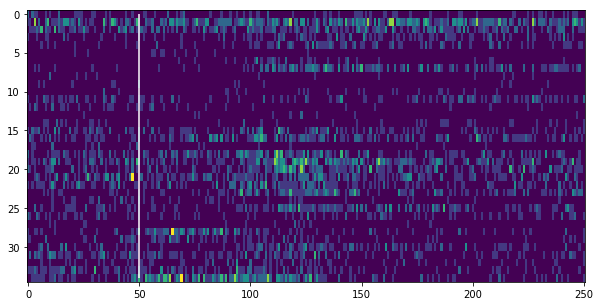

In [18]:
plt.figure(figsize=(10,5))
plt.imshow(trialavgresponse_nat1.T[:,0:500],aspect='auto')
plt.vlines(50,ymin=0,ymax=numunits-1,color='white')

# plt.figure(figsize=(10,5))
# plt.imshow(trialresponses_45[:,:,5].T[:,0:500],aspect='auto')
# plt.vlines(50,ymin=0,ymax=numunits,color='white')

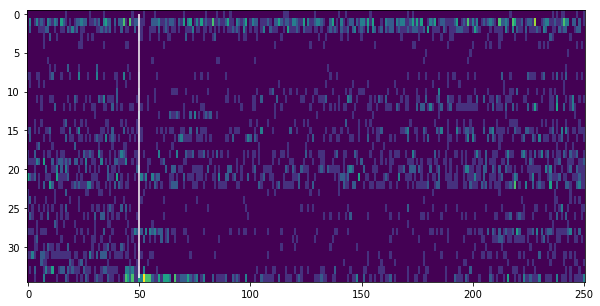

In [19]:
plt.figure(figsize=(10,5))
plt.imshow(trialavgresponse_nat2.T[:,0:500],aspect='auto')
plt.vlines(50,ymin=0,ymax=numunits-1,color='white')

# plt.figure(figsize=(10,5))
# plt.imshow(trialresponses_45[:,:,5].T[:,0:500],aspect='auto')
# plt.vlines(50,ymin=0,ymax=numunits,color='white')

In [20]:
# plt.xcorr(trialavgresponse,trialavgresponse.T)

<b>PCA and decode - stack response matrices</b>

In [21]:
#######stack all the trials so we can try to decode

# stackedresponse_45 = np.reshape(trialresponses_45,[nbins_45*ntrials_drift,numunits])
# stackedresponse_315 = np.reshape(trialresponses_315,[nbins_315*ntrials_drift,numunits])
# stackedresponse_nat1 = np.reshape(trialresponses_nat1,[nbins_nat1*ntrials_nat,numunits])
# stackedresponse_nat2 = np.reshape(trialresponses_nat2,[nbins_nat2*ntrials_nat,numunits])

# responses = np.vstack((stackedresponse_45,stackedresponse_315,stackedresponse_nat1,stackedresponse_nat2))
# labels = np.zeros(responses.shape[0])
# block1end = nbins_45 * ntrials_drift
# block2end = block1end + (nbins_315 * ntrials_drift)
# block3end = block2end + (nbins_nat1 * ntrials_nat)
# block4end = block3end + (nbins_nat2 * ntrials_nat)

# labels[0:block1end] = 0
# labels[block1end:block2end] = 1
# labels[block2end:block3end] = 2
# labels[block3end:block4end] = 3

####future steps:
#collapse each trial down to a single value (peak FR, latency to peak, etc) --> decode these


# #take 200 timepoints after stimulus presentation
# stackedresponse_45 = np.reshape(trialresponses_45[0:200,:,:],[200*ntrials_drift,numunits])
# stackedresponse_315 = np.reshape(trialresponses_315[0:200,:,:],[200*ntrials_drift,numunits])
# stackedresponse_nat1 = np.reshape(trialresponses_nat1[0:200,:,:],[200*ntrials_nat,numunits])
# stackedresponse_nat2 = np.reshape(trialresponses_nat2[0:200,:,:],[200*ntrials_nat,numunits])

# responses = np.vstack((stackedresponse_45,stackedresponse_315,stackedresponse_nat1,stackedresponse_nat2))
# labels = np.zeros(responses.shape[0])
# block1end = 200 * ntrials_drift
# block2end = block1end + (200 * ntrials_drift)
# block3end = block2end + (200 * ntrials_nat)
# block4end = block3end + (200 * ntrials_nat)

#FR in 200 bins after stimulus presentation
stackedresponse_45 = trialresponses_45[0:200,:,:].sum(axis=0)
stackedresponse_315 = trialresponses_315[0:200,:,:].sum(axis=0)
stackedresponse_nat1 = trialresponses_nat1[0:200,:,:].sum(axis=0)
stackedresponse_nat2 = trialresponses_nat2[0:200,:,:].sum(axis=0)

responses = np.vstack((stackedresponse_45.T,stackedresponse_315.T,stackedresponse_nat1.T,stackedresponse_nat2.T))

labels = np.zeros(responses.shape[0])
block1end = ntrials_drift
block2end = block1end + (ntrials_drift)
block3end = block2end + (ntrials_nat)
block4end = block3end + (ntrials_nat)



In [22]:
labels[0:block1end] = 0
labels[block1end:block2end] = 1
labels[block2end:block3end] = 2
labels[block3end:block4end] = 3

# labels = []
# block1 = ['drifting gratings 45']*(200*ntrials_drift)
# block2 = ['drifting gratings 315']*(200*ntrials_drift)
# block3 = ['natural scene 1']*(200*ntrials_nat)
# block4 = ['natural scene 2']*(200*ntrials_nat)
# labels = block1+block2+block3+block4

In [38]:
stimuniques = list(np.unique(labels))
stimuniques[0] = 'drifting gratings 45'
stimuniques[1] = 'drifting gratings 315'
stimuniques[2] = 'natural scene 1'
stimuniques[3] = 'natural scene 2'

<b>PCA</b>

Text(0.5, 1.0, 'Drift 45, Drift 315, Nat Scene 15, Nat Scene 72')

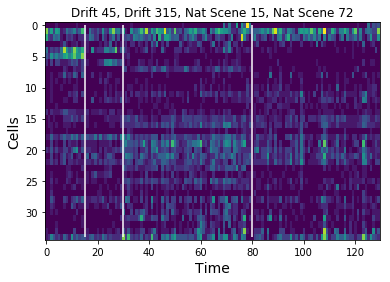

In [62]:
plt.figure()
plt.imshow(responses.T,aspect='auto');
plt.xlabel("Time", fontsize=14);
plt.ylabel("Cells", fontsize=14);
# plt.vlines([block1end,block2end,block3end],ymin=0,ymax=numunits-1,color='white')
plt.vlines([ntrials_drift,(2*ntrials_drift),(2*ntrials_drift)+ntrials_nat],ymin=0,ymax=numunits-1,color='white')
plt.title('Drift 45, Drift 315, Nat Scene 15, Nat Scene 72')

# plotname_fig1 = str(hcareas[0]) + '_FR_session' + str(seshid) +'.png'
# filename_fig1 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig1)
# plt.savefig(filename_fig1,dpi=300)

<b>sklearn PCA method</b>

In [25]:
####NOTE from PCA tutorial: probably better to normalize to the spontaneous region rather than to itself
responses_norm = responses.copy()
responses_norm -= responses.mean(axis=0)

In [26]:
pca = PCA(n_components=20)

In [27]:
pca.fit(responses_norm)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Explained variance ratio')

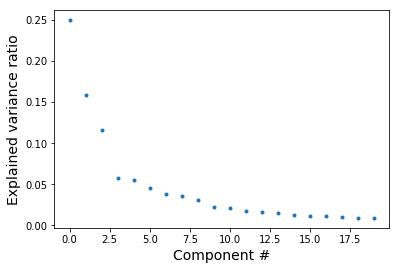

In [28]:
plt.figure()
plt.plot(pca.explained_variance_ratio_, '.')
plt.xlabel("Component #", fontsize=14)
plt.ylabel("Explained variance ratio", fontsize=14)

# plotname_fig2 = str(hcareas[0]) + '_ScreePlot_session' + str(seshid) +'.png'
# filename_fig2 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig2)
# plt.savefig(filename_fig2,dpi=300)

In [29]:
response_reduced = pca.fit_transform(responses_norm)

Text(0, 0.5, 'Second principal component')

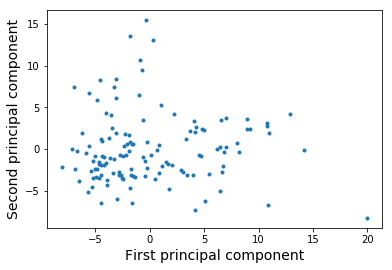

In [30]:
plt.figure()
plt.plot(response_reduced[:,0], response_reduced[:,1], '.')
plt.xlabel("First principal component", fontsize=14)
plt.ylabel("Second principal component", fontsize=14)

# plotname_fig3 = str(hcareas[0]) + '_PCAunlabeled_session' + str(seshid) +'.png'
# filename_fig3 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig3)
# plt.savefig(filename_fig3,dpi=300)

Text(0, 0.5, 'Loading_PC1')

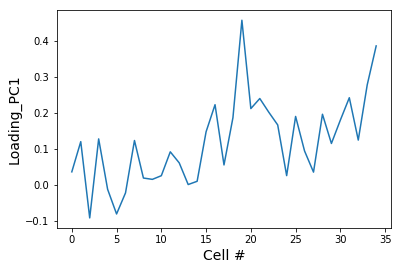

In [31]:
plt.figure()
plt.plot(pca.components_[0])
plt.xlabel("Cell #", fontsize=14)
plt.ylabel("Loading_PC1", fontsize=14)

# plotname_fig4 = str(hcareas[0]) + '_LoadingPC1_session' + str(seshid) +'.png'
# filename_fig4 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig4)
# plt.savefig(filename_fig4,dpi=300)

Text(0, 0.5, 'Loading_PC2')

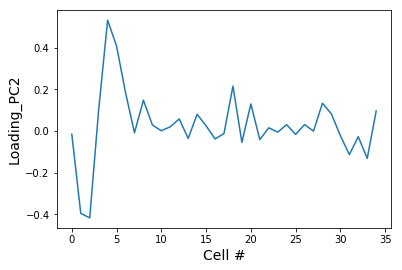

In [32]:
plt.figure()
plt.plot(pca.components_[1])
plt.xlabel("Cell #", fontsize=14)
plt.ylabel("Loading_PC2", fontsize=14)

# plotname_fig5 = str(hcareas[0]) + '_LoadingPC2_session' + str(seshid) +'.png'
# filename_fig5 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig5)
# plt.savefig(filename_fig5,dpi=300)

In [33]:
# #weird change in shape from epochrates to response_reduced, so I deal with it here
# # by ensuring labels and response_reduced are same shape
# response_reduced = response_reduced[0:labels.shape[0],:]

In [34]:
labels.shape[0], response_reduced.shape

(130, (130, 20))

In [35]:
np.unique(labels)

array([0., 1., 2., 3.])

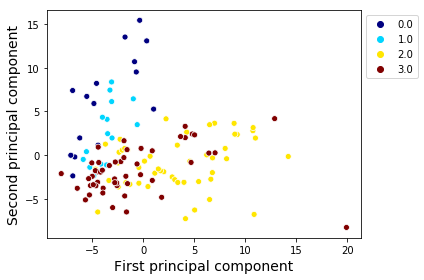

In [64]:
plt.figure()
sns.scatterplot(x=response_reduced[:,0],y=response_reduced[:,1],hue=labels,palette='jet',legend='full')
plt.xlabel("First principal component", fontsize=14)
plt.ylabel("Second principal component", fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

# plotname_fig6 = str(hcareas[0]) + '_PCA_withlabels_session' + str(seshid) +'.png'
# filename_fig6 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig6)
# plt.savefig(filename_fig6,dpi=300)

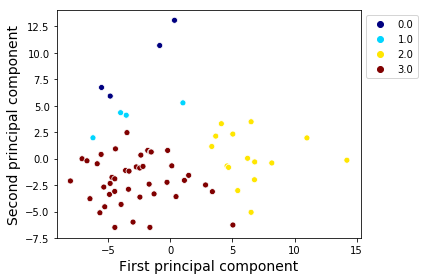

In [65]:
# [X_train,X_test,y_train,y_test] = model_selection.train_test_split(response_reduced[:,0:2],labels,test_size=0.05)
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(response_reduced[:,0:2],labels,test_size=0.5)

classifier = LDA()
classifier.fit(X_train,y_train)
y_hat = classifier.predict(X_test)

plt.figure()
sns.scatterplot(x=X_test[:,0],y=X_test[:,1],hue=y_hat,palette='jet',legend='full')
plt.xlabel("First principal component", fontsize=14)
plt.ylabel("Second principal component", fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

Text(0.5, 1.0, 'Session_744228101_Confusion')

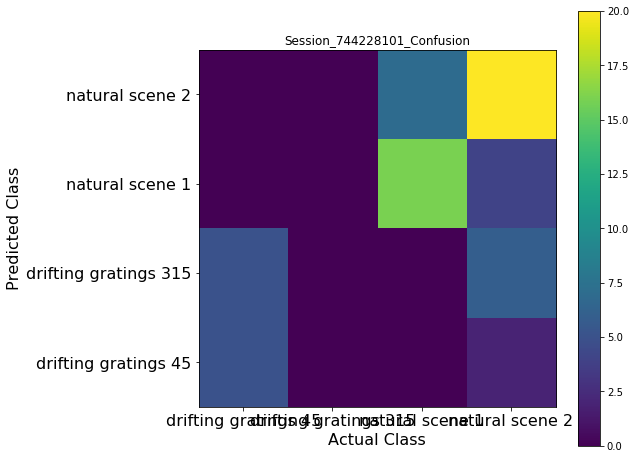

In [59]:
C = confusion_matrix(y_test,y_hat)

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.imshow(C,interpolation='none',origin='lower',vmin=0,vmax=C.max())
ax.set_xlabel('Actual Class',fontsize=16)
ax.set_ylabel('Predicted Class',fontsize=16)
ax.set_xticks(range(4))
ax.set_xticklabels(stimuniques,fontsize=16)
ax.set_yticks(range(4))
ax.set_yticklabels(stimuniques,fontsize=16)
plt.colorbar(cax)
plt.title(str('Session_'+ str(seshid) + '_Confusion'))

In [70]:
C

array([[ 5,  0,  0,  2],
       [ 5,  0,  0,  6],
       [ 0,  0, 16,  4],
       [ 0,  0,  7, 20]])

In [60]:
C.ravel()

array([ 5,  0,  0,  2,  5,  0,  0,  6,  0,  0, 16,  4,  0,  0,  7, 20])

In [86]:
df_sesh = {'Session':seshid,'Region':hcareas[0],'C':[C.ravel()]}

In [87]:
df_sesh

{'Session': 744228101,
 'Region': 'VISp',
 'C': [array([ 5,  0,  0,  2,  5,  0,  0,  6,  0,  0, 16,  4,  0,  0,  7, 20])]}

In [88]:
pd.DataFrame(data = df_sesh,index=[0,1,2])

,Session,Region,C
0,744228101,VISp,"[5, 0, 0, 2, 5, 0, 0, 6, 0, 0, 16, 4, 0, 0, 7,..."
1,744228101,VISp,"[5, 0, 0, 2, 5, 0, 0, 6, 0, 0, 16, 4, 0, 0, 7,..."
2,744228101,VISp,"[5, 0, 0, 2, 5, 0, 0, 6, 0, 0, 16, 4, 0, 0, 7,..."


In [97]:
label_natscene = np.where(epochuniques=='natural_scenes')[0][0]
label_driftgrat = np.where(epochuniques=='drifting_gratings')[0][0]
# label_natmov3 = np.where(epochuniques=='natural_movie_three')[0][0]


NameError: name 'epochuniques' is not defined

In [98]:
proj_natscene = response_reduced[labels==label_natscene]
proj_driftgrat = response_reduced[labels==label_driftgrat]

lab_natscene = labels[labels==label_natscene]
lab_driftgrat = labels[labels==label_driftgrat]

lab_NatDrift = np.append(lab_natscene,lab_driftgrat,axis=0)
proj_NatDrift = np.vstack((proj_natscene,proj_driftgrat))

epochuniq_NatDrift = epochuniques[np.unique(np.array(lab_NatDrift,dtype=int))]

NameError: name 'label_natscene' is not defined

In [32]:
lab_NatDrift.shape

(3377,)

In [31]:
proj_NatDrift.shape

(3377, 20)

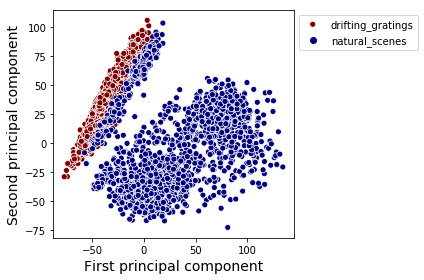

In [47]:
plt.figure()
sns.scatterplot(x=proj_NatDrift[:,0],y=proj_NatDrift[:,1],hue=lab_NatDrift,palette='jet',legend='full')
plt.xlabel("First principal component", fontsize=14)
plt.ylabel("Second principal component", fontsize=14)
plt.legend(epochuniq_NatDrift,bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

# plotname_fig6 = str(hcareas[0]) + '_PCA_withlabels_session' + str(seshid) +'.png'
# filename_fig6 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/'+ plotname_fig6)
# plt.savefig(filename_fig6,dpi=300)

In [31]:
############# 3D ADVENTURES IN EIGENSPACE #############
# %matplotlib notebook
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(response_reduced[:,0],response_reduced[:,1], response_reduced[:,2], c=labels,cmap='jet')
# ax.set_xlabel("First principal component", fontsize=14)
# ax.set_ylabel("Second principal component", fontsize=14)
# ax.set_zlabel("Third principal component", fontsize=14)
# # plt.legend(epochuniques,bbox_to_anchor=(1, 1), loc='upper left')
# plt.legend(epochuniques,loc='upper right')

<b>clustering steps</b>
1) do LDA, also SVM to decode back clusers (after split test train)
2) calculate mahalonabis distance between clusters
3) umap

<i>LDA, SVM</i>

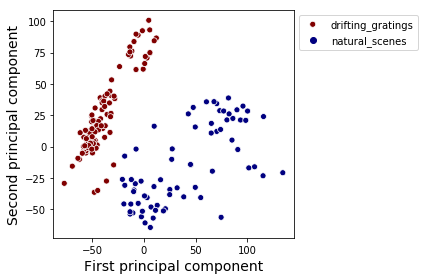

In [48]:
# [X_train,X_test,y_train,y_test] = model_selection.train_test_split(response_reduced[:,0:2],labels,test_size=0.05)
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(proj_NatDrift[:,0:2],lab_NatDrift,test_size=0.05)

classifier = LDA()
classifier.fit(X_train,y_train)
y_hat = classifier.predict(X_test)

plt.figure()
sns.scatterplot(x=X_test[:,0],y=X_test[:,1],hue=y_hat,palette='jet',legend='full')
plt.xlabel("First principal component", fontsize=14)
plt.ylabel("Second principal component", fontsize=14)
plt.legend(epochuniq_NatDrift,bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

In [50]:
C = confusion_matrix(y_test,y_hat)

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.imshow(C,interpolation='none',origin='lower',vmin=0,vmax=C.max())
ax.set_xlabel('Actual Class',fontsize=16)
ax.set_ylabel('Predicted Class',fontsize=16)
ax.set_xticks(range(2))
ax.set_xticklabels(epochuniq_NatDrift,fontsize=16)
ax.set_yticks(range(2))
ax.set_yticklabels(epochuniq_NatDrift,fontsize=16)
plt.colorbar(cax)
plt.title(str('Session_'+ str(seshid) + '_Confusion'))

NameError: name 'y_test' is not defined

In [49]:
decode_accuracy = pd.DataFrame(columns=['Session','Region','driftgrat_true','driftgrat_false',
                                        'natscene_false','natscene_true'])

df_sesh = {'Session':seshid,'Region':hcareas[0],'driftgrat_true':C[0,0],'driftgrat_false':C[0,1],
                                        'natscene_false':C[1,0],'natscene_true':C[1,1]}
decode_accuracy.append(df_sesh,ignore_index=True)

NameError: name 'C' is not defined

In [85]:
decode_accuracy.to_csv?

In [ ]:
# scores = model_selection.cross_validate(classifier,response_reduced[:,0:2],labels, cv=5, return_train_score=True)

# plt.figure(figsize=(8,8))
# ax = plt.subplot(111)
# ax.bar([0,1],[np.mean(scores['train_score']),np.mean(scores['test_score'])],color='c')
# ax.set_xticks([0.5,1.5])
# ax.set_xticklabels(['Train','Test'],fontsize=16)
# ax.set_ylabel('Fraction Correct',fontsize=16)
# plt.show()

<b>after running pca_lda_allsessions.py for CA and VISp</b>

In [100]:
#####look at discriminality across session in time.... MAKE SURE TO RETURN TO THIS

sessionnames = []
sessiontimes = []
for sesh in hc_sessions:
    sessionnames.append(sesh)
    sess = cache.get_session_data(sesh)
    sessiontimes.append(sess.session_start_time)

In [101]:
sessions_sorted = np.asarray(sessionnames)[np.argsort(sessiontimes)]

<i>Drifting gradients vs Natural scenes</i>

In [102]:
# csv_CA = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/CA/CA_LDA_accuracy_.csv')
# csv_VISp = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/VISp/VISp_LDA_accuracy_.csv')
csv_CA = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/CAdrift_LDA_accuracy.csv')
csv_VISp = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/VISpdrift_LDA_accuracy.csv')

accuracy_ca = pd.read_csv(csv_CA)
accuracy_v1 = pd.read_csv(csv_VISp)

In [103]:
#sort by Session occurrence in time

accuracy_ca['Session'] = pd.Categorical(accuracy_ca['Session'],sessions_sorted)
accuracy_ca = accuracy_ca.sort_values('Session')

accuracy_v1['Session'] = pd.Categorical(accuracy_v1['Session'],sessions_sorted)
accuracy_v1 = accuracy_v1.sort_values('Session')

In [104]:
hit_45 = [int(accuracy_v1['C'][i][8:9]) for i in range(len(accuracy_v1))]
miss_45 = [int(accuracy_v1['C'][i][11:12]) for i in range(len(accuracy_v1))]
miss_315 = [int(accuracy_v1['C'][i][14:15]) for i in range(len(accuracy_v1))]
hit_315 = [int(accuracy_v1['C'][i][17:18]) for i in range(len(accuracy_v1))]
accuracy_v1['45_hit'] = hit_45
accuracy_v1['45_miss'] = miss_45
accuracy_v1['315_miss'] = miss_315
accuracy_v1['315_hit'] = hit_315
accuracy_v1 = accuracy_v1.drop(['C'],axis=1)

calcacc_v1 = np.divide(np.add(hit_45,hit_315),np.add(np.add(hit_45,hit_315),np.add(miss_45,miss_315)))

In [105]:
hit_45 = [int(accuracy_ca['C'][i][8:9]) for i in range(len(accuracy_ca))]
miss_45 = [int(accuracy_ca['C'][i][11:12]) for i in range(len(accuracy_ca))]
miss_315 = [int(accuracy_ca['C'][i][14:15]) for i in range(len(accuracy_ca))]
hit_315 = [int(accuracy_ca['C'][i][17:18]) for i in range(len(accuracy_ca))]
accuracy_ca['45_hit'] = hit_45
accuracy_ca['45_miss'] = miss_45
accuracy_ca['315_miss'] = miss_315
accuracy_ca['315_hit'] = hit_315
accuracy_ca = accuracy_ca.drop(['C'],axis=1)

calcacc_ca = np.divide(np.add(hit_45,hit_315),np.add(np.add(hit_45,hit_315),np.add(miss_45,miss_315)))

In [106]:
import matplotlib.patches as mpatches

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


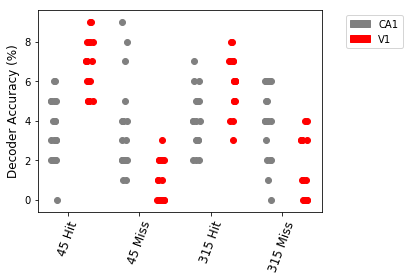

In [107]:
x_ca = [1,3,5,7]
y_ca = [accuracy_ca['45_hit'],accuracy_ca['45_miss'],accuracy_ca['315_hit'],accuracy_ca['315_miss']]

x_v1 = [2,4,6,8]
y_v1 = [accuracy_v1['45_hit'],accuracy_v1['45_miss'],accuracy_v1['315_hit'],accuracy_v1['315_miss']]

for xe, ye in zip(x_ca, y_ca):
    randlist = np.random.rand(len(ye))/5
#     randlist = np.arange(len(ye))/30
    plt.scatter([xe] * len(ye) + randlist, ye,color='grey')
for xe, ye in zip(x_v1, y_v1):
    randlist = np.random.rand(len(ye))/5
#     randlist = np.arange(len(ye))/30
    plt.scatter([xe] * len(ye) + randlist, ye,color='red')

plt.xticks([1.5,3.5,5.5,7.5],rotation=70)
plt.ylabel('Decoder Accuracy (%)',fontsize=12)
# plt.axes().set_xticklabels(df_accuracy.columns[[-4,-3,-1,-2]],fontsize=12)
plt.axes().set_xticklabels(['45 Hit','45 Miss','315 Hit', '315 Miss'],fontsize=12)
capatch = mpatches.Patch(color='gray',label='CA1')
v1patch = mpatches.Patch(color='red',label='V1')
plt.legend(handles = [capatch,v1patch],bbox_to_anchor=(1.3, 1),loc='upper right',prop={'size': 10})
plt.tight_layout()

# plotname_fig10 = 'decoder_accuracy_drift.png'
# filename_fig10 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/'+ plotname_fig10)
# plt.savefig(filename_fig10,dpi=300)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


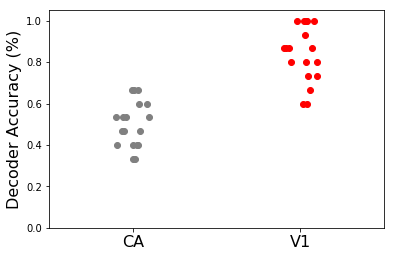

In [112]:
x_ca = 0.9
y_ca = calcacc_ca

x_v1 = 1.9
y_v1 = calcacc_v1

for ye in y_ca:
    randlist = np.random.rand()/5
    plt.scatter(x_ca + randlist, ye,color='grey')
for ye in y_v1:
    randlist = np.random.rand()/5
    plt.scatter(x_v1 + randlist, ye,color='red')

plt.xticks([1,2])
plt.ylabel('Decoder Accuracy (%)',fontsize=16)
plt.axes().set_xticklabels(['CA','V1'],fontsize=16)
# capatch = mpatches.Patch(color='gray',label='CA1')
# v1patch = mpatches.Patch(color='red',label='V1')
# plt.legend(handles = [capatch,v1patch],bbox_to_anchor=(1.3, 1),loc='upper right',prop={'size': 10})
# plt.tight_layout()
plt.xlim(0.5,2.5)
plt.ylim(0,1.05)

plotname_fig10 = 'decoder_accuracy_drift.png'
filename_fig10 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/'+ plotname_fig10)
plt.savefig(filename_fig10,dpi=300)

<i>Spontaneous vs Drifting gradients</i>

In [133]:
csv_CA = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/CA/CA_LDA_accuracy_spontdrift.csv')
csv_VISp = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/VISp/VISp_LDA_accuracy_spontdrift.csv')

accuracy_ca = pd.read_csv(csv_CA)
accuracy_v1 = pd.read_csv(csv_VISp)

In [134]:
#sort by Session occurrence in time

accuracy_ca['Session'] = pd.Categorical(accuracy_ca['Session'],sessions_sorted)
accuracy_ca = accuracy_ca.sort_values('Session')

accuracy_v1['Session'] = pd.Categorical(accuracy_v1['Session'],sessions_sorted)
accuracy_v1 = accuracy_v1.sort_values('Session')

In [135]:
import matplotlib.patches as mpatches

In [136]:
accuracy_ca.columns

Index(['Unnamed: 0', 'Session', 'Region', 'spont_true', 'spont_false',
       'driftgrat_false', 'driftgrat_true'],
      dtype='object')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


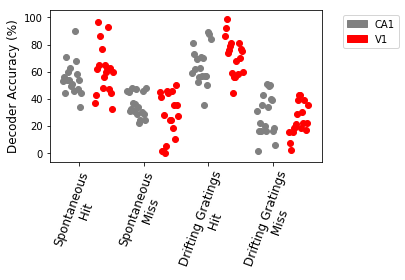

In [137]:
x_ca = [1,3,5,7]
y_ca = [accuracy_ca.spont_true,accuracy_ca.spont_false,accuracy_ca.driftgrat_true,accuracy_ca.driftgrat_false]

x_v1 = [2,4,6,8]
y_v1 = [accuracy_v1.spont_true,accuracy_v1.spont_false,accuracy_v1.driftgrat_true,accuracy_v1.driftgrat_false]

for xe, ye in zip(x_ca, y_ca):
#     randlist = np.random.rand(len(ye))/5
    randlist = np.arange(len(ye))/30
    plt.scatter([xe] * len(ye) + randlist, ye,color='grey')
for xe, ye in zip(x_v1, y_v1):
#     randlist = np.random.rand(len(ye))/5
    randlist = np.arange(len(ye))/30
    plt.scatter([xe] * len(ye) + randlist, ye,color='red')

plt.xticks([1.5,3.5,5.5,7.5],rotation=70)
plt.ylabel('Decoder Accuracy (%)',fontsize=12)
# plt.axes().set_xticklabels(df_accuracy.columns[[-4,-3,-1,-2]],fontsize=12)
plt.axes().set_xticklabels(['Spontaneous\n Hit','Spontaneous\n Miss',
                            'Drifting Gratings\n Hit', 'Drifting Gratings\n Miss'],fontsize=12)
capatch = mpatches.Patch(color='gray',label='CA1')
v1patch = mpatches.Patch(color='red',label='V1')
plt.legend(handles = [capatch,v1patch],bbox_to_anchor=(1.3, 1),loc='upper right',prop={'size': 10})
plt.tight_layout()

plotname_fig11 = 'decoder_accuracy_spontdriftgrat.png'
filename_fig11 = os.path.abspath(os.getcwd()+'/../../buzsaki_plots/PCA_LDA/'+ plotname_fig11)
plt.savefig(filename_fig11,dpi=300)

<i> mahalonabis dist </i>

In [67]:
np.unique(labels,return_counts=True)[1]

array([1764,  912,  298, 1889, 1201,  600, 1501, 1489])

In [72]:
splitarray = np.split(response_reduced[:,0],np.unique(labels,return_counts=True)[1])

TypeError: only integer scalar arrays can be converted to a scalar index

In [56]:
from sklearn.metrics import pairwise_distances

mah_dist = pairwise_distances(response_reduced,metric='mahalanobis')

In [57]:
mah_dist.shape

(9654, 9654)

<i>umap</i>

<b>Naive Bayes</b>

In [159]:
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(epochrates,epochlabels[0],test_size=0.2)

clf = GaussianNB()
clf.fit(X_train, y_train)
GaussianNB(priors=None, var_smoothing=1e-09)
y_hat = clf.predict(X_test)
y_hat
# plot_test_performance(X,Y,y_hat)

array([0, 0, 0, 0, 0, 0])

In [32]:
# def plot_test_performance(data,class_labels,prediction):
    
#     classes = np.unique(class_labels)
#     num_classes = len(classes)
    
#     color = 'rbgmyk'
    
#     plt.figure(figsize=(8,8))
#     for cl in range(num_classes):
        
#         is_class = y == cl
#         is_correct = y == prediction
        
#         plt.scatter(data[is_class & is_correct,0],
#                     data[is_class & is_correct,1],
#                     c=color[cl],edgecolor='none')
#         plt.scatter(data[is_class & ~is_correct,0],
#                     data[is_class & ~is_correct,1],
#                     c='none',edgecolor=color[cl])
        
#     plt.xlim(data[:,0].min(),data[:,0].max())
#     plt.ylim(data[:,1].min(),data[:,1].max())
#     plt.show()

In [18]:
# clf_pf = GaussianNB()
# clf_pf.partial_fit(X, Y, np.unique(Y))
# GaussianNB(priors=None, var_smoothing=1e-09)
# print(clf_pf.predict([[-0.8, -1]]))

[1]


In [49]:
#EXAMPLE

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
Y = np.array([1, 1, 1, 2, 2, 2])
X_test = np.array([[-4, -5], [-3, -1], [3, -2], [4, -1], [-2, 1], [3, 3]])

clf = GaussianNB()
clf.fit(X, Y)
GaussianNB(priors=None, var_smoothing=1e-09)
y_hat = clf.predict(X_test)
y_hat
# plot_test_performance(X,Y,y_hat)

array([1, 1, 1, 2, 1, 2])

In [ ]:
######### TO DO ##############
#confusion matrix to test accuracy